# DXdao Inverse Bonds

An exploration of the mechanism of reverse Bonds and other DXD monetary policy initiatives.

## Summary

**Smart contracts where DXD can be deposited for a defined period of time in return for a certain % of DXdao treasury assets**

Proposed Implementation from DAOtalk:
- $500k in DXD inverse bonds with 85% payout after 6 months will be issued, along with
- $500k in DXD inverse bonds with 90% of NAV payout after one year, and
- $1m in DXD Inverse bonds with 100% NAV payout after two years

Inverse bonds are an interesting way to give DXD holders an opportunity to get a better deal on selling their DXD by waiting for a set period of time. But they change how the seller interacts with the DAO and the market. The floor price already commits to buying at 70% of NAV, with DXD holders interacting with the market and not directly with the DXdao treasury. Inverse bonds have a different relationship in that they allow direct redemption of treasury assets. This begs 2 questions:

- Is one of these mechanisms preferable? (direct vs indirect redemptions)
- Is there a good reason to use both and not pick 1 of the 2 for both methods?

**What happens with direct redemptions at 70%?**
Direct redemptions move the arbitrage opportunity between the market price and redemption rate to market participants. For example, if the market price for DXD is below 70% of NAV, then market participants would buy DXD up until the point at which redemption stops being profitable. This could be considered as a value leak from the DXdao treasury to the market since in the indirect approach, DXdao should benefit from the delta between the market price and 70% of NAV. Depending on how the DAO buys DXD, this process could still be front-run by market participants to leech value. 

**What happens with direct redemptions via inverse bonds?**
When considering inverse bonds, we must now consider the time aspect to the bonds when looking at the market conditions. The first assumption I will make is that the Price of DXD at the time of bonding will be 70% of NAV. Given the schedule from DAOtalk listed above we get the following rates of return (denominated in % of NAV):

- 21.4% over 6 months (`(0.85 - 0.7)/.7)`) or 43% annually if repeated each period.
- 28.4% over 12 months (`(0.9 - 0.7)/.7)`).
- 43 % over 24 months (`(1 - 0.7)/.7)`) or 21.4% annually.

The first thing we see is that bonding over 6 months has by far the best return (43% vs 28.4% vs 21.4%). This relationship is backwards from what one would expect with an inverse bonding model. locking for longer should pay out a higher rate than locking for a shorter time.

Lets look at what different rate curves can be fit to the data:
First is a linear regression:

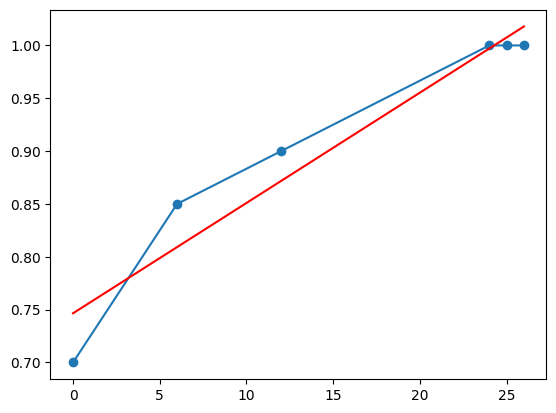

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Update the sample data
x = [0, 6, 12, 24, 25, 26]
y = [0.7, 0.85, 0.9, 1, 1, 1]

# Fit a logarithmic curve to the data
slope, intercept = np.polyfit(x, y, 1)

# Create a sequence of evenly-spaced values that covers the range of the x data points
x_values = np.linspace(min(x), max(x))

# Plot the data using matplotlib
plt.scatter(x, y)
plt.plot(x, y)
plt.plot(x_values, intercept + slope * x_values, 'r')

# Add a label showing the equation of the regression line
# equation = f'y = {intercept:.2f} + {slope:.2f} * x'
# plt.annotate(equation, (15, 0.85), fontsize=12)


This doesn't fit very well. Lets try a quadratic curve:

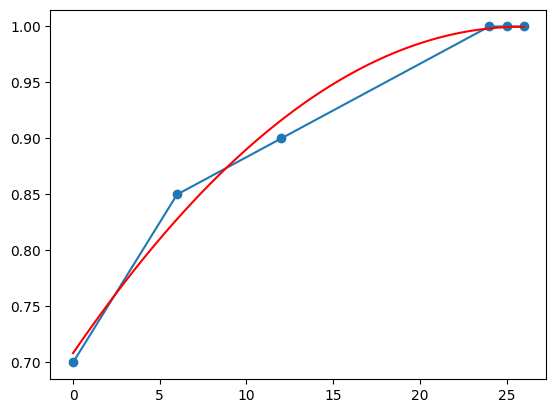

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Update the sample data
x = [0, 6, 12, 24, 25, 26]
y = [0.7, 0.85, 0.9, 1, 1, 1]

# Fit a logarithmic curve to the data
coefficients = np.polyfit(x, y, 2)

# Create a polynomial object from the coefficients
poly = np.poly1d(coefficients)

# Use the polynomial object to compute the equation of the line
equation = poly

# Create a sequence of evenly-spaced values that covers the range of the x data points
x_values = np.linspace(min(x), max(x))

# Evaluate the polynomial at the x values and plot the curve
plt.scatter(x, y)
plt.plot(x, y)
plt.plot(x_values, poly(x_values), 'r')

# Add a label showing the equation of the regression line
# plt.annotate(equation, (15, 0.85), fontsize=10)


This isn't bad if we are ok with a sharp kink upward from 70%. It still benefits shorter term bonders since the slope is greatest for the beginning of the bonding duration. I think we can do better

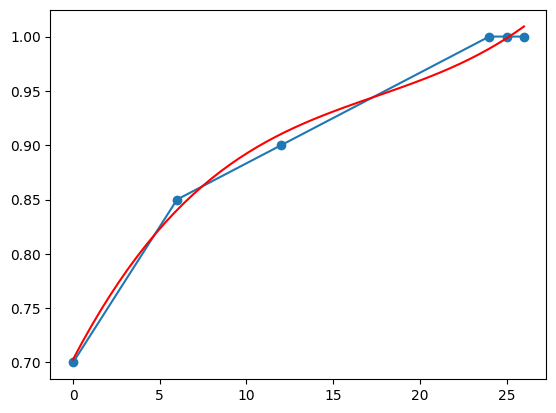

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Update the sample data
x = [0, 6, 12, 24, 25, 26]
y = [0.7, 0.85, 0.9, 1, 1, 1]

# Fit a logarithmic curve to the data
coefficients = np.polyfit(x, y, 3)

# Create a polynomial object from the coefficients
poly = np.poly1d(coefficients)
# Use the polynomial object to compute the equation of the line
equation = poly

# Create a sequence of evenly-spaced values that covers the range of the x data points
x_values = np.linspace(min(x), max(x))

# Evaluate the polynomial at the x values and plot the curve
plt.scatter(x, y)
plt.plot(x, y)
plt.plot(x_values, poly(x_values), 'r')
# Add a label showing the equation of the regression line
# plt.annotate(equation, (15, 0.85), fontsize=10)


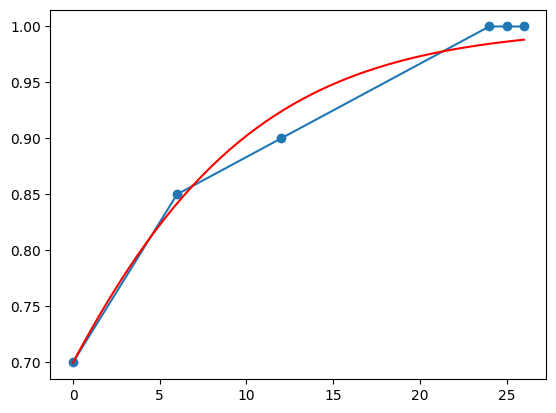

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import expit

# Update the sample data
x = [0, 6, 12, 24, 25, 26]
y = [0.7, 0.85, 0.9, 1, 1, 1]

# Define a function that computes the values of the sigmoid curve for a given set of coefficients


def sigmoid(x, a, b):
    return expit(a * x + b)


# Use curve_fit to find the coefficients that best fit the data
coefficients, _ = curve_fit(sigmoid, x, y)
a, b = coefficients

# Create a polynomial object from the coefficients
poly = np.poly1d([a, b])

# Use the polynomial object to compute the equation of the sigmoid curve
equation = poly.__str__().replace('x', '1 / (1 + e^(-x))')

# Create a sequence of evenly-spaced values that covers the range of the x data points
x_values = np.linspace(min(x), max(x))

# Evaluate the sigmoid curve at the x values and plot the curve
plt.scatter(x, y)
plt.plot(x, y)
plt.plot(x_values, sigmoid(x_values, a, b), 'r')

# Add a label showing the equation of the sigmoid curve
# plt.annotate(equation, (15, 0.85), fontsize=12)


Better, but this still benefits short term depositors. We want the curve to have minimal slope at x=0 and x=24 

y at x = 0: 0.7009897232038964
y at x = 1mo: 0.7037077371030672
y at x = 6mo: 0.736101664868972
y at x = 12mo: 0.8468708334241721
y at x = 18mo: 0.9617335574744789
y at x = 24mo: 0.9999607266349549
y at x = 12mo no interp: 0.8345470785033721
6mo returns: 10.3% per year
12mo returns: 21.0% per year
18mo returns: 24.9% per year
24mo returns: 21.4% per year


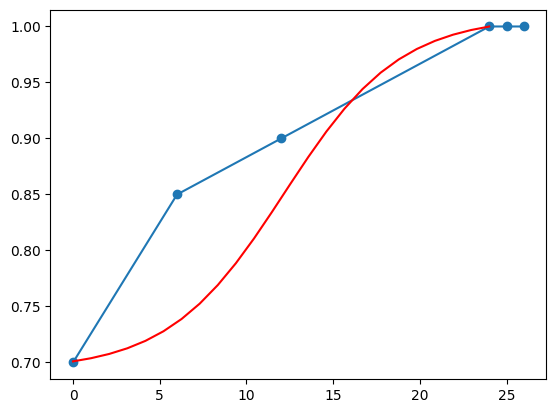

In [6]:
import numpy as np
import matplotlib.pyplot as plt
duration_in_years = 2
timeframe = 12 * (duration_in_years / 2)

# Update the sample data
x_data = [0, 6, 12, 24, 25, 26]
y_data = [0.7, 0.85, 0.9, 1, 1, 1]

# Define the range of the x-axis
x = np.linspace(-1 * timeframe, timeframe * 1, int(timeframe * 2))

# Calculate the output values for each input using the sigmoid curve
y = 0.3 / (.95 + np.exp(-.3 * x)) + (0.7 * 0.99)

# Shift the curve horizontally by adding a constant value to the x-coordinates
x_shifted = x + timeframe

# Plot the shifted curve
plt.scatter(x_data, y_data)
plt.plot(x_data, y_data)
plt.plot(x_shifted, y, 'r')

# Find the value of y at x = 0
# TODO: make function
y_at_x_0 = np.interp(0, x_shifted, y)
y_at_x_1mo = np.interp(1, x_shifted, y)
y_at_x_6mo = np.interp(6, x_shifted, y)
y_at_x_12mo = np.interp(12, x_shifted, y)
y_at_x_18mo = np.interp(18, x_shifted, y)
y_at_x_24mo = np.interp(24, x_shifted, y)
y_at_x_12mo_no_interp = y[11]

# Print the result
print(f'y at x = 0: {y_at_x_0}')
print(f'y at x = 1mo: {y_at_x_1mo}')
print(f'y at x = 6mo: {y_at_x_6mo}')
print(f'y at x = 12mo: {y_at_x_12mo}')
print(f'y at x = 18mo: {y_at_x_18mo}')
print(f'y at x = 24mo: {y_at_x_24mo}')
print(f'y at x = 12mo no interp: {y_at_x_12mo_no_interp}')

# returns
# TODO: include value function 
def calcReturns(perc_of_NAV):
    return((perc_of_NAV - 0.7)/0.7)

print(f'6mo returns: {(calcReturns(y_at_x_6mo)*2):.1%} per year')
print(f'12mo returns: {calcReturns(y_at_x_12mo):.1%} per year')
print(f'18mo returns: {(calcReturns(y_at_x_18mo)*2/3):.1%} per year')
print(f'24mo returns: {(calcReturns(y_at_x_24mo)/2):.1%} per year')


This works! We get a curve that starts at 70% and then increases slowly, reaches its fastest growth halfway through and slows down to the full payoff at the end of the time period.

This curve has a few nice properties:
- short duration locks offer minimal advantage over simply not locking.
- There is a section near the middle of the curve where the slope is maximized, meaning growth of the bond is maximized. 
- The duration of the bond could be tweaked so that the 3/4 point on the x axis is targeted as the desired bonding time (most of the value has been delivered), with diminishing returns for longer bonds. In the above plot, at 18 months, the inverse bond would pay out 96% of NAV.
- You can see the returns/year printed above for different durations held.

y at x = 0: 0.7009897232038964
y at x = 6mo: 0.7181113177568452
y at x = 12mo: 0.763398298390218
y at x = 18mo: 0.8468568360728898
y at x = 24mo: 0.9326297916814904
y at x = 30mo: 0.9812033245605024
y at x = 36mo: 0.9999607266349549
12mo bond returns: 9.1% per year
24mo bond returns: 16.6% per year
36mo bond returns: 14.3% per year


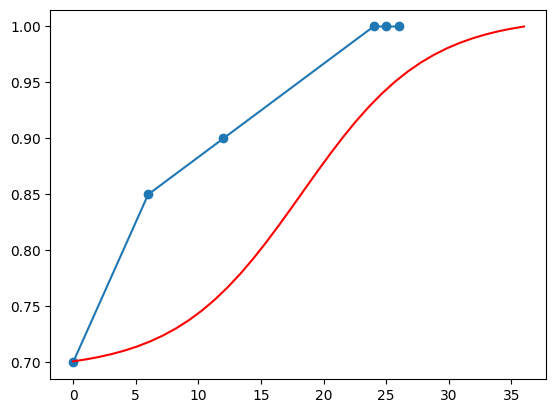

In [7]:
import numpy as np
import matplotlib.pyplot as plt
duration_in_years = 3
timeframe = 12 * (duration_in_years / 2)

# Update the sample data
x_data = [0, 6, 12, 24, 25, 26]
y_data = [0.7, 0.85, 0.9, 1, 1, 1]

# Define the range of the x-axis
x = np.linspace(-1 * timeframe, timeframe * 1, int(timeframe * 2))

# Calculate the output values for each input using the sigmoid curve
y = 0.3 / (.95 + np.exp(-.2 * x)) + (0.7 * 0.99)

# Shift the curve horizontally by adding a constant value to the x-coordinates
x_shifted = x + timeframe

# Plot the shifted curve
plt.scatter(x_data, y_data)
plt.plot(x_data, y_data)
plt.plot(x_shifted, y, 'r')

# Find the value of y at x = 0
y_at_x_0 = np.interp(0, x_shifted, y)
y_at_x_6mo = np.interp(6, x_shifted, y)
y_at_x_12mo = np.interp(12, x_shifted, y)
y_at_x_18mo = np.interp(18, x_shifted, y)
y_at_x_24mo = np.interp(24, x_shifted, y)
y_at_x_30mo = np.interp(30, x_shifted, y)
y_at_x_36mo = np.interp(36, x_shifted, y)
y_at_x_48mo = np.interp(48, x_shifted, y)

# Print the result
print(f'y at x = 0: {y_at_x_0}')
print(f'y at x = 6mo: {y_at_x_6mo}')
print(f'y at x = 12mo: {y_at_x_12mo}')
print(f'y at x = 18mo: {y_at_x_18mo}')
print(f'y at x = 24mo: {y_at_x_24mo}')
print(f'y at x = 30mo: {y_at_x_30mo}')
print(f'y at x = 36mo: {y_at_x_36mo}')

# returns
# TODO: include value function
def calcReturns(perc_of_NAV):
    return ((perc_of_NAV - 0.7)/0.7)

print(f'12mo bond returns: {(calcReturns(y_at_x_12mo)):.1%} per year')
print(f'24mo bond returns: {(calcReturns(y_at_x_24mo)/2):.1%} per year')
print(f'36mo bond returns: {(calcReturns(y_at_x_36mo)/3):.1%} per year')



Above is 36 month duration bond curve. After the 1st year it pays out at 76% of NAV. After the second year it pays 93% of NAV, and is at 99% when it hits the 3rd year. The last year has limited returns for the bonder, but it would still provide a benefit to the treasury for most bonders to take the 2 year option and re-bond since they are still selling under NAV.

## Indirect Redemptions for Inverse Bonds

It is worth asking whether it makes sense for the DAO to directly disperse treasury assets via bonding. Instead of giving the assets directly, the curve above could be use to determine how much the bond pays in DXD and then rely on the existing price floor mechanism. In the above example, after 1 year it would pay out a 9.4% bonus on the locked DXD. After the second year it would be a 33.2% bonus, and after the 3rd year it would be a 42.9% bonus. This would be paid in DXD which could then be redeemed via the floor price mechanism, sold on the open market (expected to be at 70% of NAV), or re-bonded to compound the benefits.

Again using the above curve, if Alice bonded 100 DXD for 2 years, she would get 133.2 DXD at the end of the second year. If she wanted to exit at this point, she could redeem and get roughly `133.2 * 0.70` or 93 DXD worth of assets from treasury. This greatly simplifies the role of the DXdao monetary policy committee and contracts required. They continue to manage the floor price for DXD but do not have to deal with the complexity of managing how these bonds are redeemed and deal only with DXD as an asset. 

### Added Optionality

By consolidating inverse bonds to interface only with the DXD token we make bonding something that all DXD holders participate in, not just those who are selling. Bonding could be the governance-giving mechanism for the DXD token in REP governance. The optimal strategies can be made widely accessible to maximize bonding profit, with outliers able to take other durations for their own reasons. The DXD earned when unbonding can either be considered a vesting before selling or as a bonus to be re-invested. 